In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas_helper_calc
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from pandas import Series

import warnings; warnings.simplefilter('ignore')

In [2]:
dr = pd.date_range(start='2017-02-16', end='2019-06-16')
cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

In [3]:
holidays

DatetimeIndex(['2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25',
               '2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
               '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12',
               '2018-11-22', '2018-12-25', '2019-01-01', '2019-01-21',
               '2019-02-18', '2019-05-27'],
              dtype='datetime64[ns]', freq=None)

In [18]:
path = '../big_data/sneaker_transactions.csv'

## Daily Counts - Total

In [19]:
def MakeTimeSeriesData(path):
    data = pd.read_csv(path, index_col=0)
    data.createdAt = data.createdAt.str.replace('T', ' ')
    
    data.createdAt = data.createdAt.str.split(' ').str[0]
    data.createdAt = pd.to_datetime(data.createdAt)

    time_data = data.loc[:, ('sku', 'createdAt')]
    ordered_data = time_data.sort_values('createdAt')

    daily_count = ordered_data.groupby('createdAt').count()
    daily_count['date'] = daily_count.index
    daily_count = daily_count.reset_index().loc[:, ('sku', 'date')]
    daily_count.columns = ['volume', 'date']
    daily_count.date = pd.to_datetime(daily_count.date)
    
    return(daily_count)

In [20]:
def PlotTS(data):
    volume = data['volume']
    date = data['date']
    plt.plot(date, volume)
    plt.show()

In [22]:
daily_volume = MakeTimeSeriesData(path)

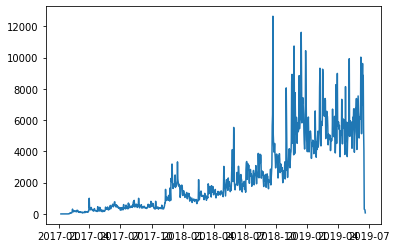

In [23]:
PlotTS(daily_volume)

In [24]:
def EngineerFeatures(daily_volume):
    over_threshold = daily_volume[daily_volume['volume'] > 100]
    
#     over_threshold['day_of_week'] = over_threshold['date'].dt.day_name()
    over_threshold['day_of_week'] = over_threshold['date'].dt.dayofweek
#     over_threshold['month'] = over_threshold['date'].dt.month_name()
    over_threshold['month'] = over_threshold['date'].dt.month
    over_threshold['year'] = over_threshold['date'].dt.year
    over_threshold['day_of_year'] = over_threshold['date'].dt.dayofyear
    over_threshold['rolling_mean_week'] = over_threshold['volume'].rolling(5).mean()
    over_threshold['rolling_median_week'] = over_threshold['volume'].rolling(5).median()
    over_threshold['rolling_sd_week'] = over_threshold['volume'].rolling(5).std()
    over_threshold['rolling_max_week'] = over_threshold['volume'].rolling(5).max()
    over_threshold['projected_volume'] = over_threshold.volume.shift(-5)

    dr = pd.date_range(start='2017-02-16', end='2019-06-16')
    df = pd.DataFrame()
    df['Date'] = dr

    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())

    over_threshold['holiday'] = over_threshold['date'].isin(holidays).astype(int)

    sneaker_releases = pd.read_csv('sneaker_metadata.csv')

    release_dates = sneaker_releases.loc[:, ('brand', 'releaseDate')]

    release_dates.releaseDate = release_dates.releaseDate.str.split(' ').str[0]
    
    grouped_release = release_dates.groupby('releaseDate').count()
    grouped_release['date'] = grouped_release.index
    grouped_release.date = pd.to_datetime(grouped_release.date)
    grouped_release = grouped_release.reset_index(drop=True)
    grouped_release.columns = ['total_release', 'date']
    
    merged_release = pd.merge(over_threshold, grouped_release, how = 'left', on='date')
    merged_release.total_release = merged_release.total_release.fillna(0)

#     jordan_release_dates = release_dates[release_dates['brand'] == 'Jordan']
#     nike_release_dates = release_dates[release_dates['brand'] == 'Nike']
#     adidas_release_dates = release_dates[release_dates['brand'] == 'adidas']

#     adidas_release_count = pd.DataFrame(adidas_release_dates.releaseDate.value_counts())
#     adidas_release_count = adidas_release_count.reset_index()
#     adidas_release_count.columns = ['date', 'adidas_releases']
#     adidas_release_count.date = pd.to_datetime(adidas_release_count.date)
    
#     jordan_release_count = pd.DataFrame(jordan_release_dates.releaseDate.value_counts())
#     jordan_release_count = jordan_release_count.reset_index()
#     jordan_release_count.columns = ['date', 'jordan_releases']
#     jordan_release_count.date = pd.to_datetime(jordan_release_count.date)

#     nike_release_count = pd.DataFrame(nike_release_dates.releaseDate.value_counts())
#     nike_release_count = nike_release_count.reset_index()
#     nike_release_count.columns = ['date', 'nike_releases']
#     nike_release_count.date = pd.to_datetime(nike_release_count.date)

#     merge_once = pd.merge(over_threshold, adidas_release_count, how='left', on='date')
#     merge_twice = pd.merge(merge_once, jordan_release_count, how='left', on='date')
#     merge_thrice = pd.merge(merge_twice, nike_release_count, how='left', on='date')

#     merge_thrice.adidas_releases = merge_thrice.adidas_releases.fillna(0)
#     merge_thrice.nike_releases = merge_thrice.nike_releases.fillna(0)
#     merge_thrice.jordan_releases = merge_thrice.jordan_releases.fillna(0)
    
    return merged_release

In [25]:
model_df = EngineerFeatures(daily_volume)

In [26]:
model_df['rolling_releases'] = model_df.total_release.iloc[::-1].rolling(5, min_periods=0).sum().iloc[::-1]

In [27]:
model_df.head(50)

,volume,date,day_of_week,month,year,day_of_year,rolling_mean_week,rolling_median_week,rolling_sd_week,rolling_max_week,projected_volume,holiday,total_release,rolling_releases
0,141,2017-02-10,4,2,2017,41,NaN,NaN,NaN,NaN,149.0,0,1.0,3.0
1,307,2017-02-11,5,2,2017,42,NaN,NaN,NaN,NaN,193.0,0,2.0,2.0
2,208,2017-02-12,6,2,2017,43,NaN,NaN,NaN,NaN,171.0,0,0.0,1.0
3,144,2017-02-13,0,2,2017,44,NaN,NaN,NaN,NaN,166.0,0,0.0,3.0
4,139,2017-02-14,1,2,2017,45,187.8,144.0,72.640898,307.0,203.0,0,0.0,3.0
5,149,2017-02-15,2,2,2017,46,189.4,149.0,71.430386,307.0,179.0,0,0.0,5.0
6,193,2017-02-16,3,2,2017,47,166.6,149.0,31.595886,208.0,162.0,0,1.0,5.0
7,171,2017-02-17,4,2,2017,48,159.2,149.0,22.498889,193.0,129.0,0,2.0,4.0
8,166,2017-02-18,5,2,2017,49,163.6,166.0,20.875823,193.0,179.0,0,0.0,2.0
9,203,2017-02-19,6,2,2017,50,176.4,171.0,21.628685,203.0,233.0,0,2.0,2.0


In [28]:
model_df.to_csv('sales_volume.csv')

## Count by brand

In [29]:
data = pd.read_csv(path, index_col=0)
sneaker_releases = pd.read_csv('sneaker_metadata.csv')

In [30]:
merged_data = data.merge(sneaker_releases, how='left', on='sku')
merged_data.createdAt = merged_data.createdAt.str.replace('T', ' ')

merged_data.createdAt = merged_data.createdAt.str.split(' ').str[0]
merged_data.createdAt = pd.to_datetime(merged_data.createdAt)

In [31]:
subset_data = merged_data.loc[:,('sku', 'brand', 'createdAt')]

In [33]:
test = pd.pivot_table(subset_data, index=['brand','createdAt'], aggfunc=len)

In [34]:
count_series = merged_data.groupby(['brand', 'createdAt']).size()

In [35]:
brand_day_counts = count_series.to_frame(name = 'count').reset_index()

In [36]:
set(brand_day_counts.brand)

{'Balenciaga',
 'Converse',
 'Crocs',
 'Jordan',
 'New Balance',
 'Nike',
 'OFF-WHITE',
 'Puma',
 'Revenge X Storm',
 'Timberland',
 'Under Armour',
 'Vans',
 'adidas'}

## Count by shoe size

In [ ]:
sneaker_releases = pd.read_csv('sneaker_metadata.csv')

release_dates = sneaker_releases.loc[:, ('brand', 'releaseDate')]
release_dates.releaseDate = release_dates.releaseDate.str.split(' ').str[0]

In [ ]:
tmp = release_dates.groupby('releaseDate').count()
tmp['date'] = tmp.index
tmp.date = pd.to_datetime(tmp.date)
tmp = tmp.reset_index(drop=True)

In [ ]:
tmp[tmp.date >= '2018-01-01']